In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns

In [2]:
tf.random.set_seed(42)

## Exploring the dataset

In [3]:
df = pd.read_csv('data/spam.csv', encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The column v1 has the labels (spam and ham) the v2 the texts and the rest of them appear to not have any data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Given that less than 1% of the Unnamed columns have values, they will be deleted.

In [5]:
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True) 

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df["v1"].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

The classes are pretty unbalanced. Class weights will be used later on to address this issue.

## Preparing the dataset

In [8]:
# Standardize labels so they have 0 for ham and 1 for spam
labels = df["v1"].apply(lambda x: 0 if x == "ham" else 1).to_numpy()

# Get the sentences
sentences = df["v2"].to_numpy()

# Create the dataset
dataset = tf.data.Dataset.from_tensor_slices((sentences, labels))

In [9]:
# Get the first 5 elements of the dataset
examples = list(dataset.take(5))

print(f"dataset contains {len(dataset)} examples\n")

print(f"Text of second example look like this: {examples[1][0].numpy().decode('latin1')}\n")
print(f"Labels of first 5 examples look like this: {[x[1].numpy() for x in examples]}")

dataset contains 5572 examples

Text of second example look like this: Ok lar... Joking wif u oni...

Labels of first 5 examples look like this: [0, 0, 1, 0, 0]


## Global Variables

In [10]:
EMBEDDING_DIM = 100
MAX_LENGTH = 32
TRAINING_SPLIT = 0.9
NUM_BATCHES = 128

## Train and Validation Datasets

In [11]:
def train_val_datasets(dataset):
    """
    Splits the dataset into training and validation sets, after shuffling it.
    """
    # Shuffle the dataset
    dataset = dataset.shuffle(buffer_size=dataset.cardinality().numpy(), reshuffle_each_iteration=False)
    
    # Compute the number of sentences that will be used for training
    train_size = int(TRAINING_SPLIT * dataset.cardinality().numpy())

    # Split the dataset
    train_dataset = dataset.take(train_size)
    validation_dataset = dataset.skip(train_size)

    # Batch the datasets
    train_dataset = train_dataset.batch(NUM_BATCHES)
    validation_dataset = validation_dataset.batch(NUM_BATCHES)
    
    return train_dataset, validation_dataset

In [12]:
# Create the train and validation datasets
train_dataset, validation_dataset = train_val_datasets(dataset)

print(f"There are {len(train_dataset)} batches for a total of {NUM_BATCHES*len(train_dataset)} elements for training.\n")
print(f"There are {len(validation_dataset)} batches for a total of {NUM_BATCHES*len(validation_dataset)} elements for validation.\n")

There are 40 batches for a total of 5120 elements for training.

There are 5 batches for a total of 640 elements for validation.



## Calculating class weights

In [13]:
# Initialize an empty list to collect labels
train_labels = []

# Iterate over the batches in the training dataset
for _, label_batch in train_dataset:
    # Convert the labels to NumPy arrays and add them to the list
    train_labels.extend(label_batch.numpy())

# Convert the list of labels to a NumPy array
train_labels = np.array(train_labels)

In [14]:
# Get unique classes and their counts in the training data
classes, class_counts = np.unique(train_labels, return_counts=True)

# Total number of samples in the training data
total_samples = len(train_labels)

# Number of classes (should be 2 for 'ham' and 'spam')
num_classes = len(classes)

# Calculate class weights
class_weights = {}

for i in range(num_classes):
    class_weight = total_samples / (num_classes * class_counts[i])
    class_weights[classes[i]] = class_weight

print("Class Weights:", class_weights)

Class Weights: {0: 0.5775167012209168, 1: 3.725111441307578}


## Vectorizer

In [15]:
def fit_vectorizer(dataset):
    """
    Adapts the TextVectorization layer on the training sentences
    
    Args:
        dataset (tf.data.Dataset): Tensorflow dataset with training sentences.
    
    Returns:
        tf.keras.layers.TextVectorization: an instance of the TextVectorization class adapted to the training sentences.
    """    

    
    # Instantiate the TextVectorization class, defining the necessary arguments alongside their corresponding values
    vectorizer = tf.keras.layers.TextVectorization( 
        standardize="lower_and_strip_punctuation",
        output_sequence_length=MAX_LENGTH
    ) 
    
    # Fit the tokenizer to the training sentences
    vectorizer.adapt(dataset)
       
    return vectorizer

In [16]:
# Get only the texts out of the dataset
text_only_dataset = train_dataset.map(lambda text, label: text)

# Adapt the vectorizer to the training sentences
vectorizer = fit_vectorizer(text_only_dataset)

# Check size of vocabulary
vocab_size = vectorizer.vocabulary_size()

print(f"Vocabulary contains {vocab_size} words\n")

Vocabulary contains 8986 words



In [17]:
# Apply vectorization to train and val datasets
train_dataset_vectorized = train_dataset.map(lambda x,y: (vectorizer(x), y))
validation_dataset_vectorized = validation_dataset.map(lambda x,y: (vectorizer(x), y))

## Pre-defined Embeddings

In [18]:
# Define path to file containing the embeddings
glove_file = 'data/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
glove_embeddings = {}

# Read file and fill glove_embeddings with its contents
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coefs

In [19]:
# Create a word index dictionary
word_index = {x:i for i,x in enumerate(vectorizer.get_vocabulary())}

In [20]:
# Initialize an empty numpy array with the appropriate size
embeddings_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the embeddings_matrix array
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

## Model

In [21]:
def create_model(vocab_size, pretrained_embeddings):
    """
    Creates a binary sentiment classifier model
    
    Args:
        vocab_size (int): Number of words in the vocabulary.
        pretrained_embeddings (np.ndarray): Array containing pre-trained embeddings.

    Returns:
        (tf.keras Model): the sentiment classifier model
    """
  
    model = tf.keras.Sequential([ 
        tf.keras.Input(shape=(MAX_LENGTH,)),
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[pretrained_embeddings], trainable=False),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPooling1D(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.l2()),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    
    model.compile( 
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["accuracy"] 
    ) 

    return model

In [22]:
# Create your untrained model
model = create_model(vocab_size, embeddings_matrix)

In [23]:
# Train the model and save the training history
history = model.fit(
	train_dataset_vectorized, 
	epochs=30, 
	validation_data=validation_dataset_vectorized,
    class_weight=class_weights
)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.6012 - loss: 0.8239 - val_accuracy: 0.9588 - val_loss: 0.4062
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9278 - loss: 0.4324 - val_accuracy: 0.9659 - val_loss: 0.2868
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9521 - loss: 0.3391 - val_accuracy: 0.9695 - val_loss: 0.2461
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9559 - loss: 0.2749 - val_accuracy: 0.9409 - val_loss: 0.2960
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9607 - loss: 0.2499 - val_accuracy: 0.9534 - val_loss: 0.2579
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9586 - loss: 0.2093 - val_accuracy: 0.9498 - val_loss: 0.2375
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9643 - loss: 0.1747 - val_accuracy: 0.9624 - val_loss: 0.1753
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9760 - loss: 0.1360 - val_accuracy: 0.9749 - v

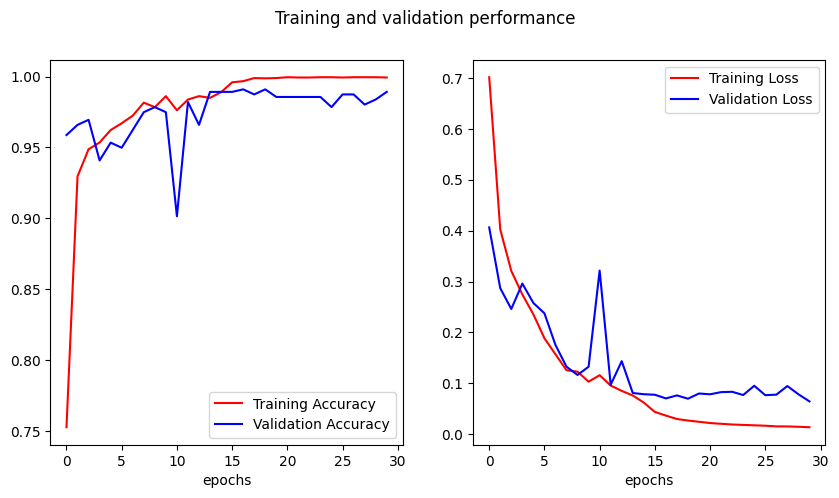

In [24]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation performance')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

## Making predictions

In [25]:
def predict_email_content(model, vectorizer, email_content):
    """
    Predicts whether the given email content is 'spam' or 'ham' and displays the confidence.

    Args:
        model (tf.keras.Model): The trained spam classifier model.
        vectorizer (tf.keras.layers.TextVectorization): The fitted TextVectorization layer.
        email_content (str): The content of the email to classify.

    Returns:
        tuple: A tuple containing the label ('spam' or 'ham') and the confidence score.
    """
    # Preprocess the email content using the vectorizer
    email_vector = vectorizer(tf.constant([email_content]))
    
    # Use the model to make a prediction
    prediction = model.predict(email_vector)
    
    # Extract the probability of being 'spam'
    probability_spam = prediction[0][0]
    
    # Determine the label and adjust the probability accordingly
    if probability_spam >= 0.5:
        label = 'spam'
        confidence = probability_spam  # Confidence in 'spam'
    else:
        label = 'ham'
        confidence = 1 - probability_spam  # Confidence in 'ham'
    
    # Convert confidence to percentage
    confidence_percent = confidence * 100
    
    # Print the result
    print(f"The email is classified as **{label.upper()}** with a confidence of {confidence_percent:.2f}%")
    
    return label, confidence

In [26]:
# Example of a spam email
spam_email = "Congratulations! You've won a free ticket to the Bahamas. Call now to claim your prize."

# Predict using the function
label, probability = predict_email_content(model, vectorizer, spam_email)

# Example of a ham email
ham_email = "Hi John, how are you doing?"

# Predict using the function
label, probability = predict_email_content(model, vectorizer, ham_email)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
The email is classified as **SPAM** with a confidence of 99.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The email is classified as **HAM** with a confidence of 99.80%


In [27]:
email_1 = "Dear Valued Customer, Congratulations! You have been selected to receive a special reward worth $1,000. To claim your prize, please click on the link below and complete the short survey. [Claim Your Reward Now](http://example.com/reward) Don't miss this limited-time offer! Best regards, The Rewards Team"
# Predict using the function
label, probability = predict_email_content(model, vectorizer, email_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The email is classified as **SPAM** with a confidence of 98.94%


In [28]:
email_2 = """Subject: Meeting Agenda for Tomorrow

Hi Team,

Please find attached the agenda for our meeting scheduled tomorrow at 10:00 AM. Make sure to review the documents beforehand so we can have a productive discussion.

Looking forward to your valuable inputs.

Best,
Jessica
Project Manager
"""

label, probability = predict_email_content(model, vectorizer, email_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
The email is classified as **HAM** with a confidence of 99.71%


In [29]:
email_3 = """Subject: Urgent: Update Your Payment Information

Dear User,

We noticed an issue with your billing information. To avoid any interruption in your service, please update your payment details immediately.

[Secure Update Link](http://secure-update.example.com)

Thank you for your prompt attention to this matter.

Sincerely,
Billing Department
"""

label, probability = predict_email_content(model, vectorizer, email_3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
The email is classified as **SPAM** with a confidence of 99.83%


In [30]:
email_4 = """Subject: Exclusive Investment Opportunity Just for You

Dear Investor,

Are you looking for a way to double your money in just a few months? We have an exclusive investment opportunity that is guaranteed to yield high returns with minimal risk.

Don't let this chance slip away. Contact us now to learn more.

Best regards,
Global Investments Inc.
"""

label, probability = predict_email_content(model, vectorizer, email_4)
# This one was meant to be spam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
The email is classified as **HAM** with a confidence of 98.32%


## Confusion Matrix

In [31]:
# Initialize lists to store true labels and predictions
y_true = []
y_pred = []

# Iterate over the validation dataset
for x_batch, y_batch in validation_dataset_vectorized:
    # Get model predictions
    preds = model.predict(x_batch)
    # Convert probabilities to binary class labels
    preds_class = (preds >= 0.5).astype(int).flatten()
    # Extend the lists
    y_pred.extend(preds_class)
    y_true.extend(y_batch.numpy().flatten())

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate precision
precision = precision_score(y_true, y_pred)
print(f"Precision: {precision:.4f}")

# Calculate recall
recall = recall_score(y_true, y_pred)
print(f"Recall: {recall:.4f}")

# Calculate F1 score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9892
Precision: 0.9722
Recall: 0.9459
F1 Score: 0.9589


In [33]:
# Generate and print the classification report
report = classification_report(y_true, y_pred, target_names=['Ham', 'Spam'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         Ham       0.99      1.00      0.99       484
        Spam       0.97      0.95      0.96        74

    accuracy                           0.99       558
   macro avg       0.98      0.97      0.98       558
weighted avg       0.99      0.99      0.99       558



In [34]:
# Compute and print the confusion matrix
cm = confusion_matrix(y_true, y_pred)

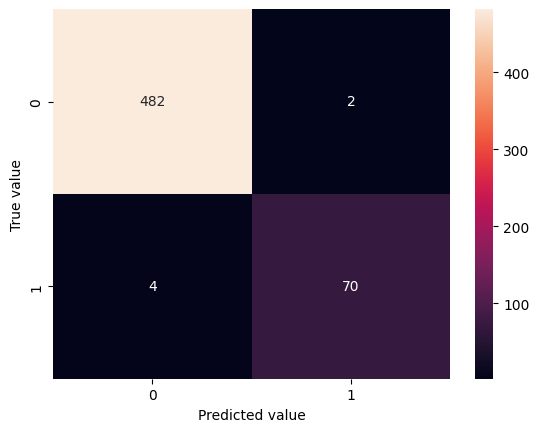

In [35]:
sns.heatmap(cm, annot=True, fmt="g")
plt.xlabel('Predicted value')
plt.ylabel('True value')
plt.show()

## Checking Misclassified Emails

In [36]:
# Train emails
texts = []
labels = []
y_pred_classes = []
# Iterate over batches in the train dataset

for text_batch, label_batch in train_dataset:
    # Convert texts to strings
    batch_texts = [text.decode('latin1') for text in text_batch.numpy()]
    texts.extend(batch_texts)
    labels.extend(label_batch.numpy())

    # Vectorize texts
    inputs = vectorizer(tf.constant(batch_texts))

    # Get model predictions
    y_pred = model.predict(inputs)
    preds_class = (y_pred >= 0.5).astype(int).flatten()
    y_pred_classes.extend(preds_class)
 
# Convert lists to NumPy arrays
labels = np.array(labels)
y_pred_classes = np.array(y_pred_classes)

# Identify misclassified emails
for i in range(len(texts)):
    if y_pred_classes[i] != labels[i]:
        print(f"Email index {i}:")
        print(f"Text:\n{texts[i]}")
        print(f"True label: {'Ham' if labels[i]==0 else 'Spam'}")
        print(f"Predicted label: {'Ham' if y_pred_classes[i]==0 else 'Spam'}")
        print("-" * 50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━

In [37]:
# Validations emails
texts = []
labels = []
y_pred_classes = []
# Iterate over batches in the train dataset

for text_batch, label_batch in validation_dataset:
    # Convert texts to strings
    batch_texts = [text.decode('latin1') for text in text_batch.numpy()]
    texts.extend(batch_texts)
    labels.extend(label_batch.numpy())

    # Vectorize texts
    inputs = vectorizer(tf.constant(batch_texts))

    # Get model predictions
    y_pred = model.predict(inputs)
    preds_class = (y_pred >= 0.5).astype(int).flatten()
    y_pred_classes.extend(preds_class)
 
# Convert lists to NumPy arrays
labels = np.array(labels)
y_pred_classes = np.array(y_pred_classes)

# Identify misclassified emails
for i in range(len(texts)):
    if y_pred_classes[i] != labels[i]:
        print(f"Email index {i}:")
        print(f"Text:\n{texts[i]}")
        print(f"True label: {'Ham' if labels[i]==0 else 'Spam'}")
        print(f"Predicted label: {'Ham' if y_pred_classes[i]==0 else 'Spam'}")
        print("-" * 50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Email index 11:
Text:
Ee msg na poortiyagi odalebeku: Hanumanji 7 name 1-Hanuman 2-Bajarangabali 3-Maruti 4-Pavanaputra 5-Sankatmochan 6-Ramaduth 7-Mahaveer ee 7 name  &lt;#&gt;  janarige ivatte kalisidare next saturday olage ondu good news keluviri...! Maretare inde 1 dodda problum nalli siguviri idu matra  &lt;#&gt; % true.. Don't neglet.
True label: Ham
Predicted label: Spam
--------------------------------------------------
Email index 209:
Text:
Not heard from U4 a while. Call me now am here all night with just my knickers on. Make me beg for it like U did last time 01223585236 XX Luv Nikiyu4.net
True label: Spam
Predicted label: Ham
--------------------------------------------------
Email index 212:
Text:
Hi babe its Chloe, how r u? I was smashed on saturday night, it was great! How was your w

## Analysis

The misclassified emails highlight specific challenges the model faces:

- False Positives (Ham misclassified as Spam):  
        - Messages with unusual formatting, lists, or certain keywords can be misinterpreted as spam.  
        - The model may be overly sensitive to specific words or structures without considering the overall context.

- False Negatives (Spam misclassified as Ham):  
        - Spam messages that use a personal or conversational tone are harder for the model to detect.  
        - Subtle spam indicators, such as mentions of costs or promotional content embedded in friendly language, may not be weighted heavily enough by the model.

## Model Summary

In [38]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 100)        │       898,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 28, 64)         │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50)             │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,051,293 (4.01 MB)

 Trainable params: 50,897 (198.82 KB)

 Non-trainable params: 898,600 (3.43 MB)

 Optimizer params: 101,796 (397.64 KB)